# Introduction to Parallel Machine Scheduling

Parallel machine scheduling is a fundamental area in operations research and computer science, focusing on the allocation of jobs to multiple machines running in parallel. The objective is typically to optimize certain performance metrics, such as minimizing the total completion time (makespan), reducing job tardiness, or balancing the workload among machines.

## Types of Parallel Machine Environments
 - Identical Machines ($P_{m}$): All machines have the same processing capabilities. A job takes the same amount of time on any machine.
 - Uniform Machines ($Q_{m}$): Machines have different speeds. A job's processing time varies inversely with the machine's speed.
 - Unrelated Machines ($R_{m}$): Processing times vary arbitrarily for each machine-job pair due to differing capabilities or efficiencies.

## Objectives in Scheduling
 - Makespan Minimization ($C_{max}$): Minimize the total time to complete all jobs.
 - Sum of Job Completion Times ($\sum C_{j}$): Minimize the sum of completion times for all jobs.
 - Tardiness- and Lateness- related objectives: Ensure jobs meet their due dates.
 - Load Balancing: Distribute workloads evenly across machines.

## Applications
 - Manufacturing systems
 - Cloud computing and data centers
 - Project management
 - Transportation and logistics


The following code block imports some libraries we will use to demonstrate key concepts and scheduling techniques.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

The following code block defines a function for creating a Gantt chart from a dictionary specifying details of the schedule (more information on the structure of this dictionary later).

In [2]:
def make_gantt_chart(schedule_details_dict):

    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    
    for machine in schedule_details_dict:
        for job in schedule_details_dict[machine]:
            start_time = schedule_details_dict[machine][job]['start_time']
            completion_time = schedule_details_dict[machine][job]['completion_time']
            length = completion_time - start_time
            ax.barh(
                machine, 
                length,
                left=start_time, 
                edgecolor='black',
            )
            ax.text(
                start_time + length/2,
                machine,
                job,
                va='center',
                ha='center',
                color='k',
            )
        ax.spines[['right', 'top']].set_visible(False)
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Machines')
    ax.set_title('Gantt Chart')
    plt.show()

# Scheduling with Identical Machines ($P_{m}$)
In this setting, all machines are identical, and a job's processing time is the same on any machine. This simplifies the problem.

## List Scheduling

Approach: Assign jobs to machines in the order they appear, always selecting the machine that becomes available first.
Objective: Minimize makespan by greedily assigning jobs to the earliest available machine.

Algorithm Steps
1. Initialize Machines: Set the ready time of each machine to 0.
2. Assign Jobs:
 - For each job in the list:
   - Select the machine with the earliest ready time.
   - Assign the job to this machine.
   - Update the machine's ready time by adding the job's processing time.

The makespan is the maximum of all machines' ready times after scheduling.

For identical machines, the List Scheduling algorithm guarantees a makespan no more than $\displaystyle \left(2 - \frac{1}{m}\right)OPT$, where OPT is the optimal makespan.

The following code block creates a DataFrame with some sample data.

In [3]:
jobs = 20

np.random.seed(42)

random_pj_values = np.random.randint(low=5, high=30, size=jobs)
random_pj_values.sort()
PM_data = [{'j': f'J{idx}', 'pj': int(val)} for idx, val in enumerate(random_pj_values, 1)]
PM_data = pd.DataFrame(PM_data)
PM_data = PM_data.set_index('j')

The following code block defines the list scheduling procedure.

In [4]:
number_of_machines = 4

schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

for job in PM_data.index:
    sorted_machines = sorted(schedules.items(), key=lambda x: x[1]['ready_time'])
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + PM_data.loc[job, 'pj']
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time

The following code block creates a dictionary of schedule details

In [5]:
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + PM_data.loc[job, 'pj']
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

The following code block creates a Gantt chart based on the schedule details.

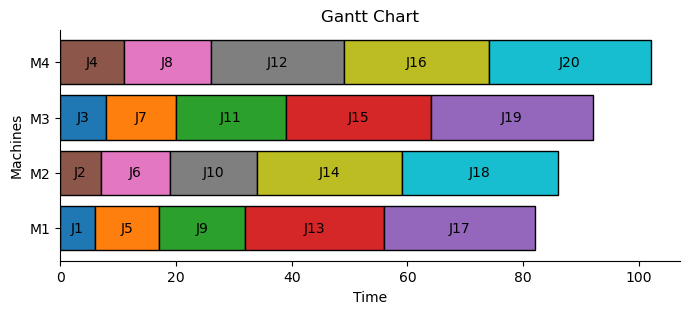

In [6]:
make_gantt_chart(schedule_details)

We will now look at what happens if we sort the jobs in decreasing order of processing times (Longest Processing Time rule) before applying the list scheduling algorithm. The following code block applies the LPT sort to the PM_data.

In [7]:
PM_data = PM_data.sort_values('pj', ascending=False)

The following code block applies the list scheduling procedure to the sorted jobs.

In [8]:
number_of_machines = 4

schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

for job in PM_data.index:
    sorted_machines = sorted(schedules.items(), key=lambda x: x[1]['ready_time'])
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + PM_data.loc[job, 'pj']
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time

The following code block creates the schedule details object.

In [9]:
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + PM_data.loc[job, 'pj']
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

The following code block plots the Gantt chart.

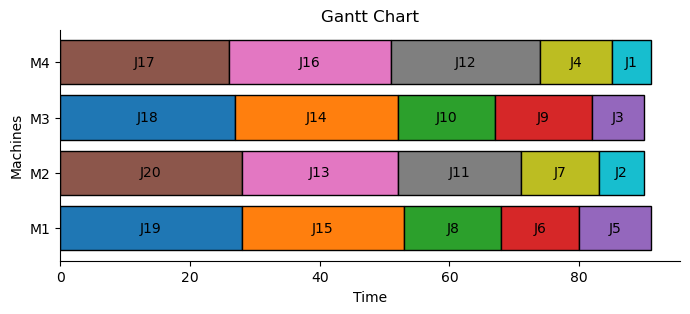

In [10]:
make_gantt_chart(schedule_details)

# Scheduling with Uniform Machines ($Q_{m}$)
In this setting, each job requires a fixed amount of work, and the machines vary in the amount of work they can perform per unit of time. In other words, machines have different speeds.

The following code block generates some sample data for a uniform parallel machine environment. The speed of the machine, i.e., units of work that can be performed per unit of time, is the same as its index. For example, machine 1 can perform 1 unit of work per unit time, machine 2 can perform 2 units of work per unit time, etc.

In [11]:
jobs = 20
number_of_machines = 4

np.random.seed(42)

random_work_values = np.random.randint(low=10, high=31, size=jobs)
QM_data = [{'j': f'J{idx}', 'work': int(val)} for idx, val in enumerate(random_work_values, 1)]
QM_data = pd.DataFrame(QM_data)
QM_data = QM_data.set_index('j')

machine_speeds = {f'M{i}': i for i in range(1, number_of_machines+1)}
for machine, speed in machine_speeds.items():
    QM_data[machine] = QM_data['work']/speed

QM_data.head()

,work,M1,M2,M3,M4
j,,,,,
J1,16,16.0,8.0,5.333333,4.00
J2,29,29.0,14.5,9.666667,7.25
J3,24,24.0,12.0,8.000000,6.00
J4,20,20.0,10.0,6.666667,5.00
J5,17,17.0,8.5,5.666667,4.25


Since the ordering of jobs from shortest to longest will be the same on any machine, we can sort by the processing time on any machine to get an LPT sort. The following code block sorts by the processing times on machine M1.

In [12]:
QM_data = QM_data.sort_values(
    'M1',
    ascending=False,
)

The following code block uses a list scheduling approach that is modified to schedule jobs to the machine where they will complete the earliest.

In [13]:
number_of_machines = 4

schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

for job in QM_data.index:
    sorted_machines = sorted(
        schedules.items(), 
        key=lambda x: x[1]['ready_time'] + QM_data.loc[job, x[0]]
    )
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + QM_data.loc[job, selected_machine]
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time
schedules

{'M1': {'ready_time': np.float64(39.0), 'schedule': ['J3', 'J18']},
 'M2': {'ready_time': np.float64(40.0),
  'schedule': ['J11', 'J17', 'J13', 'J14']},
 'M3': {'ready_time': np.float64(41.0),
  'schedule': ['J20', 'J2', 'J10', 'J5', 'J7', 'J16']},
 'M4': {'ready_time': np.float64(42.0),
  'schedule': ['J15', 'J6', 'J8', 'J4', 'J9', 'J1', 'J12', 'J19']}}

The following code block uses the schedules determined in the previous cell to construct the `schedule_details` dictionary that can be used to generate a Gantt chart.

In [14]:
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + QM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

The following code block generates the Gantt chart

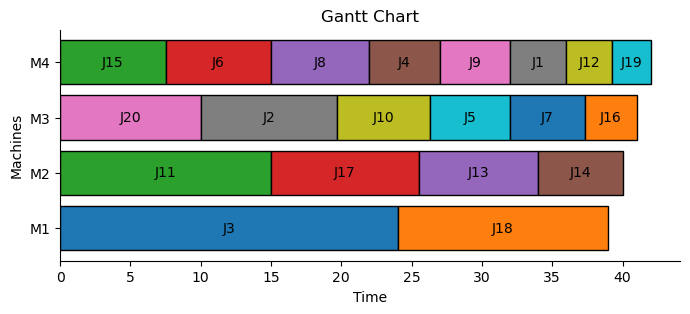

In [15]:
make_gantt_chart(schedule_details)

# Scheduling with Unrelated Machines ($R_{m}$)
In this setting, processing times vary by job/machine combination. The following code block generates some sample data for an unrelated parallel machine environment.

In [16]:
jobs = 20
number_of_machines = 4

np.random.seed(42)

random_pj_values = np.random.randint(low=10, high=31, size=(jobs, number_of_machines))

RM_data = pd.DataFrame(
    random_pj_values,
    columns=[f'M{idx}' for idx in range(1, number_of_machines + 1)],
    index=[f'J{idx}' for idx in range(1, jobs + 1)]
)
RM_data.head()

,M1,M2,M3,M4
J1,16,29,24,20
J2,17,30,16,28
J3,20,20,30,13
J4,17,12,30,11
J5,21,15,11,30


In an unrelated parallel machine enviroment, sorting the jobs in LPT order is not possible since the processing time varies by job and machine. In other words, a job that takes a long time on one machine may complete very quickly on another. Thus, we have options in howwe sort jobs. Some potential options are:
- sort from longest mean processing time to shortest mean processing time
- sort from longest max processing time to shortest max processing time

We will consider both options. 

## Sorting Jobs by Mean Processing Time

First, we will consider sorting the jobs by mean processing time.

In [17]:
RM_data['mean_pij'] = RM_data.mean(axis=1)

RM_data = RM_data.sort_values(
    'mean_pij',
    ascending=False,
)

The following code block uses a list scheduling approach that is modified to schedule jobs to the machine where they will complete the earliest.

In [18]:
number_of_machines = 4

schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

for job in RM_data.index:
    sorted_machines = sorted(
        schedules.items(), 
        key=lambda x: x[1]['ready_time'] + RM_data.loc[job, x[0]]
    )
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + RM_data.loc[job, selected_machine]
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time
schedules

{'M1': {'ready_time': np.int64(89),
  'schedule': ['J19', 'J2', 'J9', 'J3', 'J6', 'J17']},
 'M2': {'ready_time': np.int64(81), 'schedule': ['J7', 'J14', 'J16', 'J13']},
 'M3': {'ready_time': np.int64(88),
  'schedule': ['J11', 'J1', 'J12', 'J5', 'J15']},
 'M4': {'ready_time': np.int64(81),
  'schedule': ['J20', 'J8', 'J18', 'J10', 'J4']}}

The following code block uses the schedules determined in the previous cell to construct the `schedule_details` dictionary that can be used to generate a Gantt chart.

In [19]:
processing_time_data = RM_data.copy()

schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + RM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

The following code block generates the Gantt chart

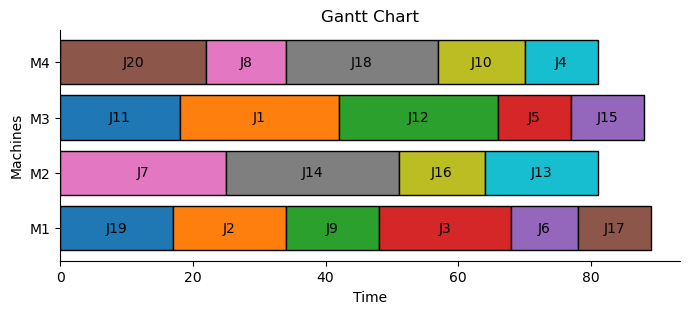

In [20]:
make_gantt_chart(schedule_details)

## Sorting Job by Max Processing Time

We will now consider sorting jobs by the max processing time

In [21]:
RM_data = RM_data.sort_index()
RM_data['max_pij'] = RM_data.max(axis=1)

RM_data = RM_data.sort_values(
    'max_pij',
    ascending=False,
)

The following code block uses a list scheduling approach that is modified to schedule jobs to the machine where they will complete the earliest.

In [22]:
number_of_machines = 4

schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

for job in RM_data.index:
    sorted_machines = sorted(
        schedules.items(), 
        key=lambda x: x[1]['ready_time'] + RM_data.loc[job, x[0]]
    )
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + RM_data.loc[job, selected_machine]
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time
schedules

{'M1': {'ready_time': np.int64(76),
  'schedule': ['J2', 'J20', 'J12', 'J6', 'J17']},
 'M2': {'ready_time': np.int64(81), 'schedule': ['J19', 'J8', 'J16', 'J13']},
 'M3': {'ready_time': np.int64(86),
  'schedule': ['J11', 'J5', 'J9', 'J14', 'J18', 'J15']},
 'M4': {'ready_time': np.int64(81),
  'schedule': ['J3', 'J4', 'J1', 'J10', 'J7']}}

The following code block uses the schedules determined in the previous cell to construct the `schedule_details` dictionary that can be used to generate a Gantt chart.

In [23]:
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + RM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

The following code block generates the Gantt chart

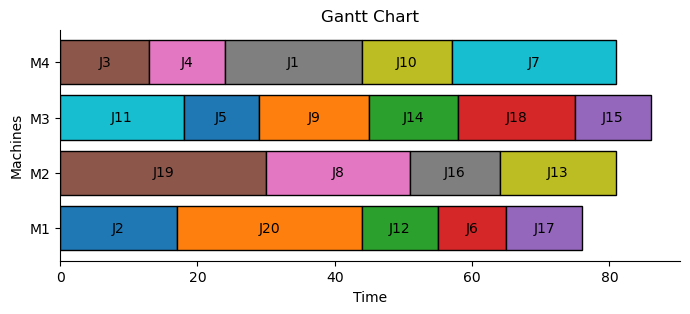

In [24]:
make_gantt_chart(schedule_details)

# Incorporating Other Objectives

The construction heuristics we have seen up to this point have largely focused on how to assign jobs to machines in order to minimize makespan. In general, this is a good first step that will aim to balance the workload across the machines evenly. However, it may be that other objectives are important as well.

## Minimizing Sum of Completion Times

Suppose we have an unrelated parallel machine environment and our objective is to minimize the sum of job completion times. We may begin by using the list scheduling approach with jobs sorted by their maximum processing time across machines to construct an initial solution. This is done in the following code block.

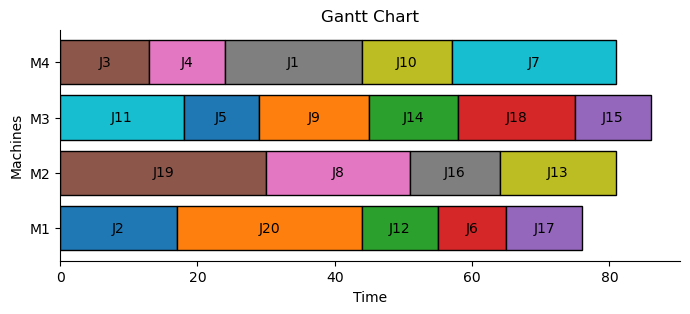

In [25]:
number_of_machines = 4

# sort data by max pij
RM_data = RM_data.sort_index()
RM_data['max_pij'] = RM_data.max(axis=1)

RM_data = RM_data.sort_values(
    'max_pij',
    ascending=False,
)

# initialize schedules dictionary
schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

# apply list scheduling
for job in RM_data.index:
    sorted_machines = sorted(
        schedules.items(), 
        key=lambda x: x[1]['ready_time'] + RM_data.loc[job, x[0]]
    )
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + RM_data.loc[job, selected_machine]
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time

# get details for Gantt chart
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + RM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

# make Gantt chart
make_gantt_chart(schedule_details)

The following code block computes the sum of job completion times

In [26]:
sum_of_completion_times = 0
for machine in schedule_details:
    for job in schedule_details[machine]:
        sum_of_completion_times += schedule_details[machine][job]['completion_time']

print(f'{sum_of_completion_times = :,}')

sum_of_completion_times = 1,013


When we looked at single machine scheduling, we noted that scheduling jobs in SPT order was optimal for $1//\sum C_{j}$. Based on this, we would expect to get a better objective value by sorting the jobs assigned to each machine in SPT order. The following code does this for the previously generated schedule, updates the `schedule_details` object, and plots a revised Gantt chart.

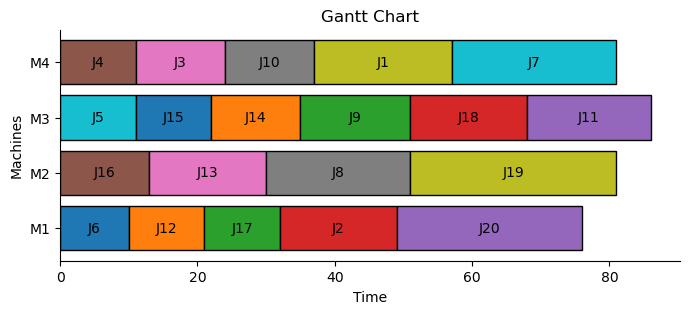

In [27]:
number_of_machines = 4

# sort data by max pij
RM_data = RM_data.sort_index()
RM_data['max_pij'] = RM_data.max(axis=1)

RM_data = RM_data.sort_values(
    'max_pij',
    ascending=False,
)

# initialize schedules dictionary
schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

# apply list scheduling
for job in RM_data.index:
    sorted_machines = sorted(
        schedules.items(), 
        key=lambda x: x[1]['ready_time'] + RM_data.loc[job, x[0]]
    )
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + RM_data.loc[job, selected_machine]
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time

# apply SPT sort for individual machines
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    
    SPT_sort = RM_data.loc[machine_schedule, machine].sort_values()
    SPT_sort = SPT_sort.index.tolist()
    schedules[machine]['schedule'] = SPT_sort

# get details for Gantt chart
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + RM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

# make Gantt chart
make_gantt_chart(schedule_details)

The following code block prints the updated sum of completion times.

In [28]:
sum_of_completion_times = 0
for machine in schedule_details:
    for job in schedule_details[machine]:
        sum_of_completion_times += schedule_details[machine][job]['completion_time']

print(f'{sum_of_completion_times = :,}')

sum_of_completion_times = 846


# Neighborhood Search

We will now look at applying a neighborhoos search approach to the unrelated data to see if we can improve upon the schedule identified by the list scheduling approach.

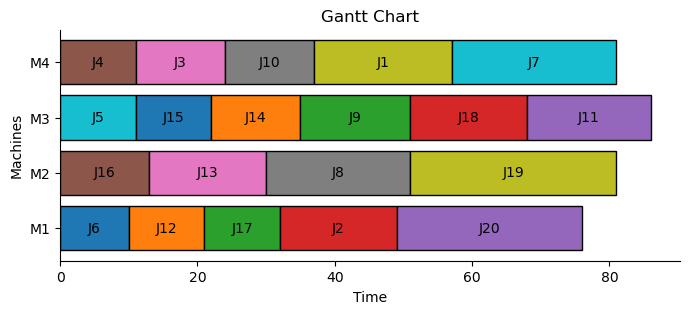

In [29]:
number_of_machines = 4

# sort data by max pij
RM_data = RM_data.sort_index()
RM_data['max_pij'] = RM_data.max(axis=1)

RM_data = RM_data.sort_values(
    'max_pij',
    ascending=False,
)

# initialize schedules dictionary
schedules = {}
for machine_idx in range(1, number_of_machines+1):
    schedules[f'M{machine_idx}'] = {'ready_time': 0, 'schedule': []}

# apply list scheduling
for job in RM_data.index:
    sorted_machines = sorted(
        schedules.items(), 
        key=lambda x: x[1]['ready_time'] + RM_data.loc[job, x[0]]
    )
    selected_machine = sorted_machines[0][0]
    
    start_time = schedules[selected_machine]['ready_time']
    completion_time = start_time + RM_data.loc[job, selected_machine]
    schedules[selected_machine]['schedule'].append(job)
    schedules[selected_machine]['ready_time'] = completion_time

# apply SPT sort for individual machines
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    
    SPT_sort = RM_data.loc[machine_schedule, machine].sort_values()
    SPT_sort = SPT_sort.index.tolist()
    schedules[machine]['schedule'] = SPT_sort

# get details for Gantt chart
schedule_details = {}
for machine in schedules:
    machine_schedule = schedules[machine]['schedule']
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + RM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

# make Gantt chart
make_gantt_chart(schedule_details)

We will import a couple of aditional libraries to help out with the neighborhood search.

In [30]:
import copy
import random

We will first define a function to swap the machine that two jobs are assigned to.

In [31]:
def get_swap_neighbor(starting_solution):

    neighbor = copy.deepcopy(starting_solution)

    m1, m2 = np.random.choice(
        list(neighbor.keys()), 
        size=2, 
        replace=False,
    ).tolist()
    
    m1_job = np.random.choice(neighbor[m1])
    m2_job = np.random.choice(neighbor[m2])
    
    neighbor[m1].remove(m1_job)
    neighbor[m2].remove(m2_job)
    
    neighbor[m1].append(m2_job)
    neighbor[m2].append(m1_job)

    return neighbor

We will first define a function to move a job from one machine to another.

In [32]:
def get_move_neighbor(starting_solution):

    neighbor = copy.deepcopy(starting_solution)

    m1, m2 = np.random.choice(
        list(neighbor.keys()), 
        size=2, 
        replace=False,
    ).tolist()
    
    m1_job = np.random.choice(neighbor[m1])
    
    neighbor[m1].remove(m1_job)
    neighbor[m2].append(m1_job)

    return neighbor

The following function defines a function to apply a shortest processing time sort to a generated neighbor.

In [33]:
def SPT_sort_schedule(starting_solution, processing_time_df):

    sorted_schedule = {}
    
    for machine in starting_solution:
        machine_schedule = starting_solution[machine]
        
        SPT_sort = processing_time_df.loc[machine_schedule, machine].sort_values()
        SPT_sort = SPT_sort.index.tolist()
        sorted_schedule[machine] = SPT_sort

    return sorted_schedule

The following code block defines a function to compute the sum of completion times for a neighbor solution.

In [34]:
def compute_sum_cj(starting_solution, processing_time_df):
    
    sum_cj = 0.0
    for machine in starting_solution:
        sum_cj += processing_time_df.loc[starting_solution[machine], machine].cumsum().sum()
    
    return sum_cj

The following code block implements the neighborhood search procedure.

In [35]:
best_solution = {machine: val['schedule'] for machine, val in schedules.items()}
best_sum_cj = compute_sum_cj(best_solution, RM_data)

max_iterations = 1_000
iteration = 0
while iteration < max_iterations:
    iteration += 1
    if random.random() <= 0.5:
        neighbor = get_move_neighbor(best_solution)
    else:
        neighbor = get_swap_neighbor(best_solution)
    neighbor = SPT_sort_schedule(neighbor, RM_data)
    neighbor_sum_cj = compute_sum_cj(neighbor, RM_data)
    if neighbor_sum_cj < best_sum_cj:
        best_solution = {key: val for key, val in neighbor.items()}
        best_sum_cj = neighbor_sum_cj
        iteration = 0
        print(f' - Improvement to {best_sum_cj}')

 - Improvement to 845.0
 - Improvement to 839.0
 - Improvement to 830.0
 - Improvement to 827.0
 - Improvement to 811.0
 - Improvement to 802.0
 - Improvement to 793.0
 - Improvement to 791.0


The following code block generates the Gantt chart

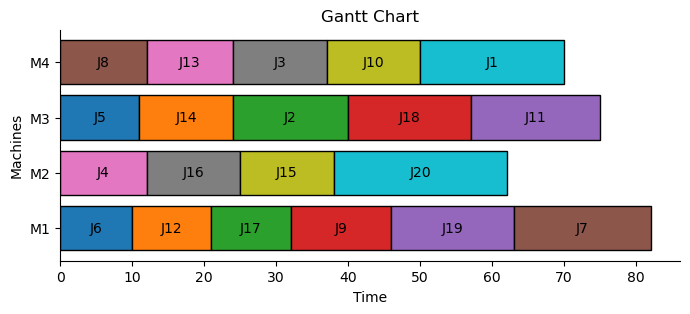

In [36]:
schedule_details = {}
for machine in best_solution:
    machine_schedule = best_solution[machine]
    start_time = 0
    machine_details = {}
    for job in machine_schedule:
        completion_time = start_time + RM_data.loc[job, machine]
        machine_details[job] = {
            'start_time': start_time,
            'completion_time': completion_time,
        }
        start_time = completion_time
    schedule_details[machine] = machine_details

make_gantt_chart(schedule_details)